## Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from seaborn import heatmap
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
df = pd.read_json('logins.json')

In [3]:
df.sort_values(by='login_time',inplace=True)

In [4]:
df.head(10)

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
5,1970-01-01 20:21:41
10,1970-01-01 20:26:05
4,1970-01-01 20:26:21
11,1970-01-01 20:31:03
12,1970-01-01 20:34:46


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 6 to 93140
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [6]:
# make a copy of df
new_df=df.copy()
#create new column to store number of logins
new_df['num_logins']=1
# calculate number of logins within every 15 minuts
new_df = new_df.set_index('login_time').resample('15min').sum()

In [7]:
new_df.head()

,num_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [8]:
new_df.describe()

,num_logins
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


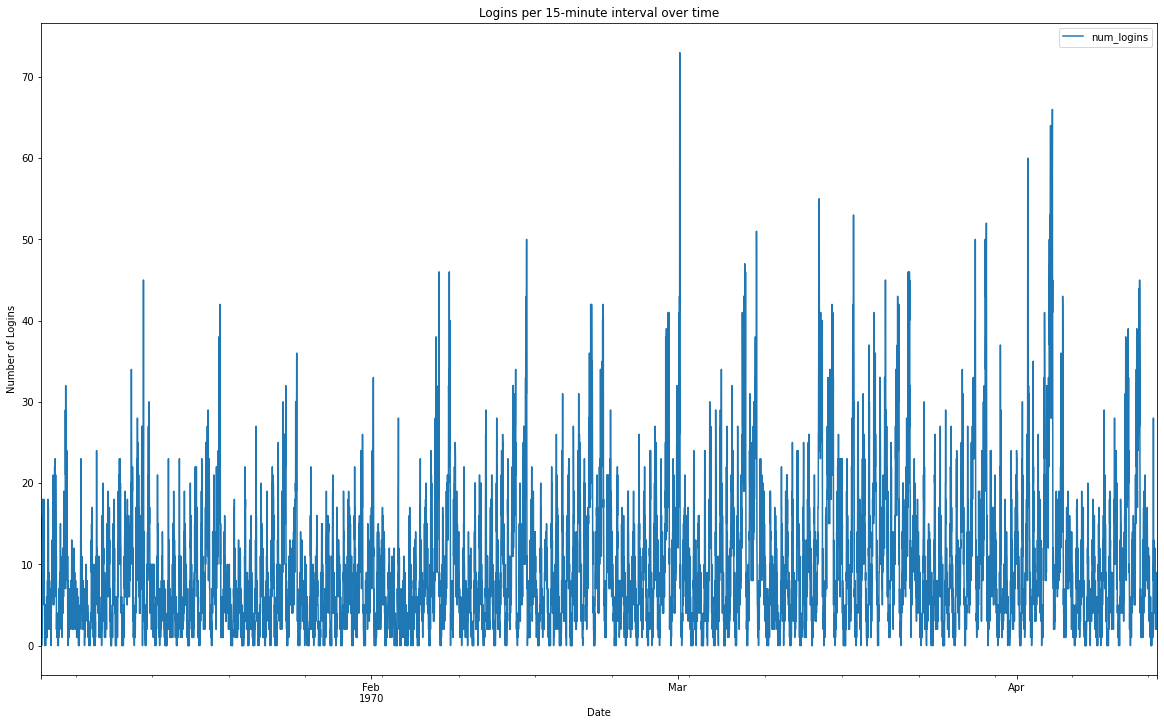

In [9]:
#plot the results
new_df.plot(xlabel='Date', ylabel='Number of Logins', figsize=(20,12), kind='line')
plt.title('Logins per 15-minute interval over time')
plt.show()

it seems pattern is not stationary since there is a trend of number of login during time and also seems to have seasonality in the pattern. in next step I will decompose the signal to see if there is any trend or seasonality.

In [10]:
decomp = seasonal_decompose(new_df.num_logins, period=2688)

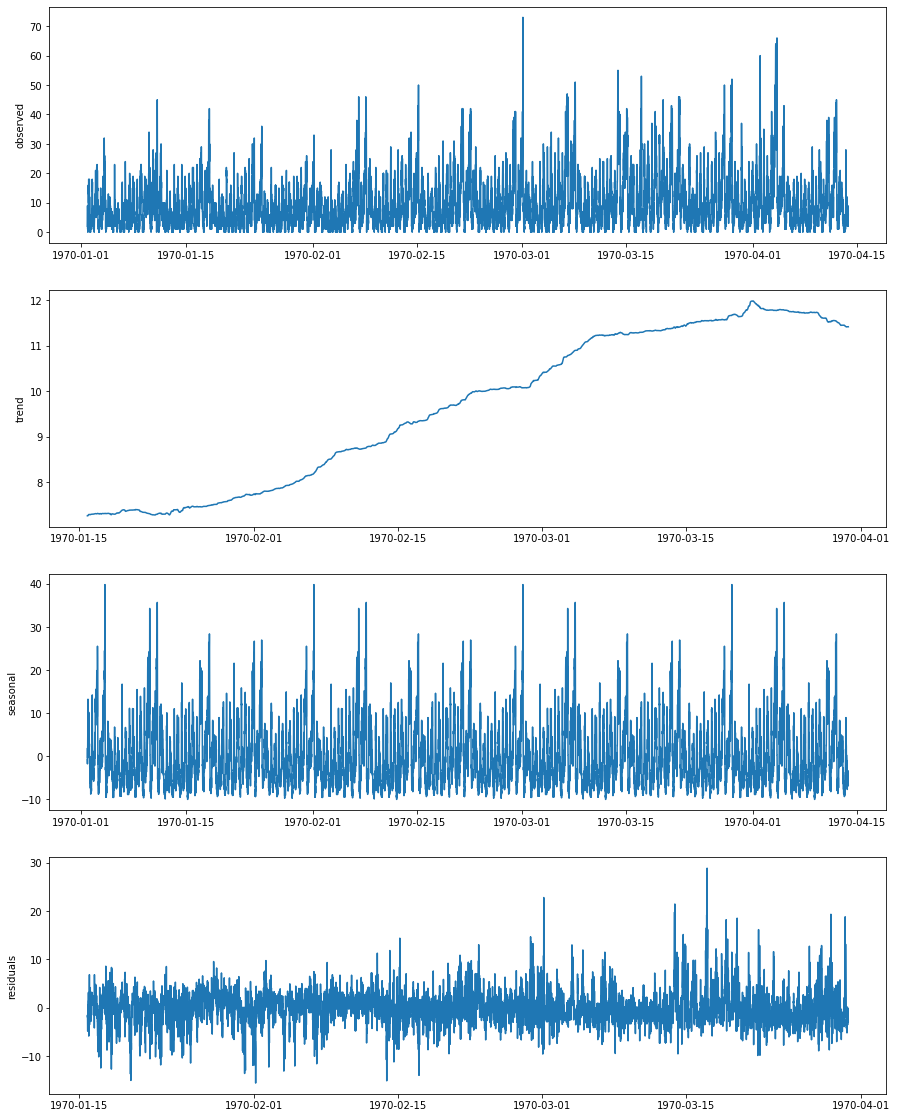

In [11]:
# Plot the original data, the trend, the seasonality, and the residuals 
fig, ax = plt.subplots(4, figsize=(15,20))

for i, attrib, name in zip([i for i in range(4)],
                        [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid], 
                        ['observed', 'trend', 'seasonal', 'residuals']):
    ax[i].plot(attrib)
    ax[i].set_ylabel(name)
    
plt.show()

As we can see there is a trend and seasonality in the signal. Now we need to explore the data daily and hourly.

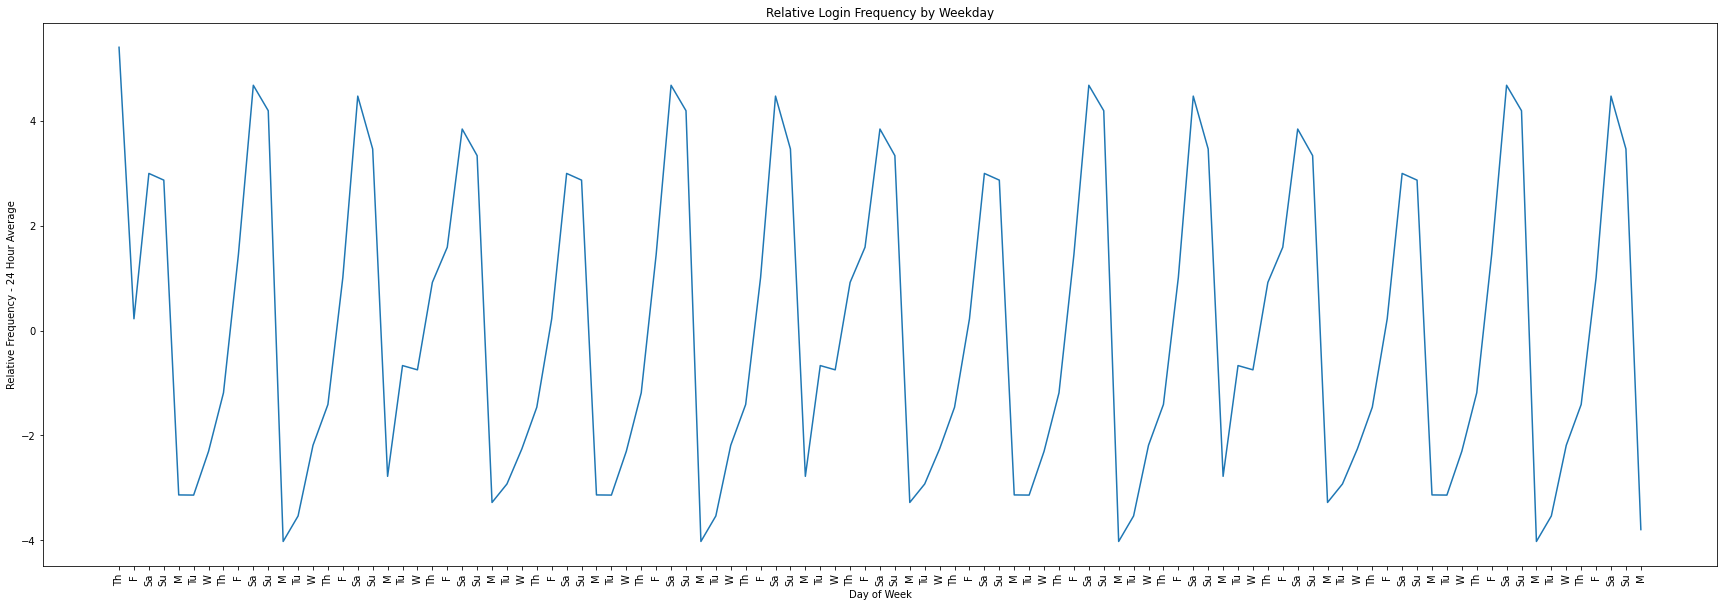

In [12]:
daily = decomp.seasonal.resample('1D').mean()
day_dict = {0:'M', 1:'Tu', 2:'W', 3:'Th', 4:'F', 5:'Sa', 6:'Su'}
#plot the last month of data
plt.figure(figsize=(30,10))
plt.plot(daily.index, daily.values)
plt.xticks(ticks=daily.index, 
           labels=daily.index.weekday.map(day_dict))
plt.xlabel('Day of Week')
plt.ylabel('Relative Frequency - 24 Hour Average')
plt.title('Relative Login Frequency by Weekday')
plt.xticks(rotation=90)
plt.show()

There is a clear pattern with higher relative login frequency towards the end of the week and on the weekend, with a peak on Saturday and a drastic drop on Monday. We can look at daily patterns and how they change throughout the week as well.

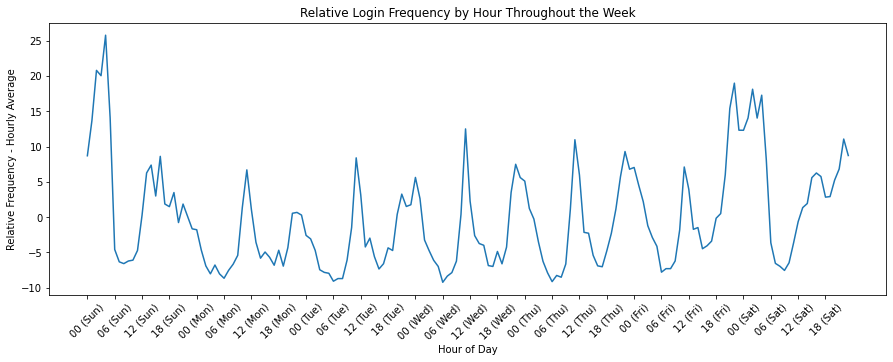

In [13]:
# resample hourly
hourly = decomp.seasonal.resample('1H').mean()

# changing i allows us to plot different weeks
i=1

# plot 
plt.figure(figsize=(15,5))
plt.plot(hourly[52 +7*24*i: 220 + 7*24*i].index, hourly[52 +7*24*i: 220 + 7*24*i].values)
plt.xticks(ticks=hourly[52 +7*24*i: 220 + 7*24*i:6].index, 
           labels=hourly[52 +7*24*i: 220 + 7*24*i:6].index.strftime('%H (%a)'),
           rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Relative Frequency - Hourly Average')
plt.title('Relative Login Frequency by Hour Throughout the Week')
plt.show()

there is a peak logins around the lunch hour (12:00), and then a broader increase in logins during the evenings through to the next morning (from 6:00PM to 5:00AM with peak around 9PM to midnight). Weekends have broader ranges of increases in login times, with higher traffic more evenly distributed throughout the day and slightly later peak times in the evenings (~midnight to 2AM) with the highest login frequencies late Saturday night / early Sunday morning. Note that this a consistent pattern across weeks, which can be inspected by changing 'i' in the code above.

In summary, login demands are highest during the lunch hour and in the evenings, increase throughout the week, increase on the last week of the month, and have had an increasing baseline from January to April.

## Part 2 - Experiment and Metrics Design
1.The new policy is looking for encouraging drivers to be available in both cities or would like to communicate between cities. The metric that I think would be the best to describe this is to calculate increasing average number of driving that login in one city and communicate to other. To do this we can calculate the proportion of drivers communicated between cities in one day and make average in week or month to see if there is an increase in this average compare to same average before new policy.

2a. I think we can select the random subset of drivers to receive the toll reimbursement to be the treatment group and the remaining drivers would serve as the control group. The subset of reimbursed drivers would need to be representative of the entire pool of drivers. the average of drivers that communicated between cities would be collected for a given amount of time (e.g. one month) before and after the promotion.

2b. Once the data is collected we can use the t-test with the 95% confidence interval for both the set of treatment and control average to determine if they are significantly different from each other. 

2c. By calculating the p-value we can determined that if the different is statistically significant or not. 

## Part 3 - Preditive Modeling

In [14]:
df = pd.read_json('ultimate_data_challenge.json', convert_dates=['signup_date', 'last_trip_date'])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

`avg_rating_of_driver`, `phone type` and `avg_rating_by_driver` fields have missing values.

In [16]:
df[df['avg_rating_of_driver'].isnull()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [17]:
df.trips_in_first_30_days[df['avg_rating_of_driver'].isnull()].value_counts()

1    3987
0    3749
2     334
3      45
4       6
5       1
Name: trips_in_first_30_days, dtype: int64

as we can see more than 90% of null values for `avg_rating_of_driver` are for drivers with less than 2 trips in first 30 days. lets take a look at value counts for those divers in each city.

In [18]:
df.city[df['avg_rating_of_driver'].isnull()].value_counts()

Winterfell        3952
Astapor           2887
King's Landing    1283
Name: city, dtype: int64

In [19]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

array([[<AxesSubplot:title={'center':'Astapor'}>,
        <AxesSubplot:title={'center':"King's Landing"}>],
       [<AxesSubplot:title={'center':'Winterfell'}>, <AxesSubplot:>]],
      dtype=object)

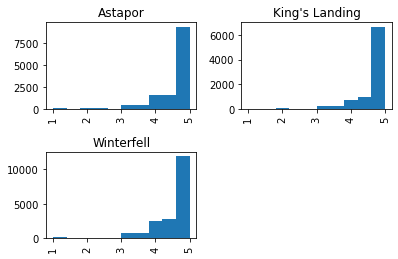

In [20]:
df.avg_rating_of_driver.hist(by=df['city'])

In [21]:
print('the median of average rating of drivers in each city',df.avg_rating_of_driver.groupby(df['city']).median())
print('the mean of average rating of drivers in each city',df.avg_rating_of_driver.groupby(df['city']).mean())

the median of average rating of drivers in each city city
Astapor           5.0
King's Landing    5.0
Winterfell        4.8
Name: avg_rating_of_driver, dtype: float64
the mean of average rating of drivers in each city city
Astapor           4.630593
King's Landing    4.706997
Winterfell        4.532996
Name: avg_rating_of_driver, dtype: float64


based of above information I will fill null values for average rating of drivers by mean of rating in each city. I will do the same for `avg_rating_by_driver`.

In [22]:
df.avg_rating_of_driver = df.groupby('city')['avg_rating_of_driver'].apply(lambda x: x.fillna(x.mean()))
df.avg_rating_by_driver = df.groupby('city')['avg_rating_by_driver'].apply(lambda x: x.fillna(x.mean()))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [24]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

we still have some null values for phone type since I have no information about the type of phone they used I fill none values with others.

In [25]:
df.phone = df.phone.fillna(value='other')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

To calculate if a driver was active in the preceding 30 days we can used 30 days before last  trip date.

In [27]:
df.last_trip_date.describe()

C:\Users\HP\.conda\envs\capstone\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [28]:
df['retained'] = (df.last_trip_date >= pd.to_datetime('2014-06-01')).astype('int')

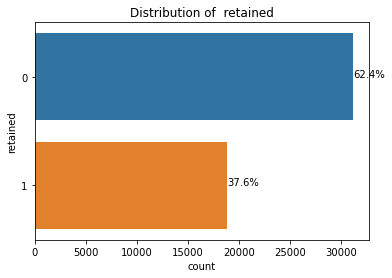

In [29]:
ax = sns.countplot(y="retained", data=df)
plt.title('Distribution of  retained')


total = len(df['retained'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

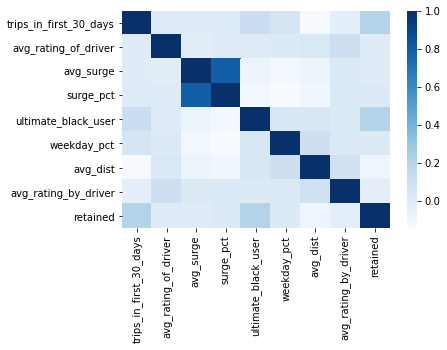

In [30]:
heatmap(df.corr(), cmap='Blues')
plt.show()

In [31]:
df.corr()['retained']

trips_in_first_30_days    0.210463
avg_rating_of_driver     -0.007525
avg_surge                -0.003333
surge_pct                 0.011797
ultimate_black_user       0.205002
weekday_pct               0.009693
avg_dist                 -0.092780
avg_rating_by_driver     -0.026591
retained                  1.000000
Name: retained, dtype: float64

## Modeling

In [32]:
df.ultimate_black_user = df.ultimate_black_user.astype('int')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retained                50000 non-null  int32 

In [34]:
df = pd.get_dummies(df,columns=['city', 'phone'])
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0,0


In [35]:
df.drop(columns=['signup_date','last_trip_date'], inplace=True)

In [36]:
X = df.drop(columns='retained')
y = df['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [39]:
rf = RandomForestClassifier()
params = {
 'max_depth': [ 10, 50, 100],
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [ 500, 1000]
}

grid_search = GridSearchCV(estimator=rf,verbose=3, param_grid=params, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 75.8min finished


In [40]:
grid_result.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 500}

In [37]:
best_model = RandomForestClassifier(criterion='entropy',max_depth=50,max_features='sqrt',min_samples_leaf=4
                                   ,min_samples_split=10,n_estimators=500)

In [39]:
best_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500)

In [40]:
y_pred = best_model.predict(X_test)

In [41]:
confusion_matrix(y_test, y_pred)

array([[8034, 1345],
       [1938, 3683]], dtype=int64)

In [43]:
accuracy_score(y_test, y_pred)

0.7811333333333333

In [46]:
precision_recall_fscore_support(y_test, y_pred,average='macro')

(0.769076923739693, 0.755908005254768, 0.7610264133193692, None)

In [42]:
feature_importances = [best_model.feature_importances_]
feature_importances = pd.DataFrame(feature_importances, columns=X.columns)

feature_importances = feature_importances.transpose().rename({0:'feature_importances'}, axis=1)

In [47]:
feature_importances.sort_values('feature_importances', ascending=False)

,feature_importances
avg_dist,0.169336
weekday_pct,0.147857
avg_rating_by_driver,0.130675
surge_pct,0.097253
trips_in_first_30_days,0.083214
avg_surge,0.080633
city_King's Landing,0.072311
avg_rating_of_driver,0.065724
ultimate_black_user,0.046583
phone_Android,0.033890


## Conclusion

Higher average distance customers should be given perks in order to increase retention.Based on our model, we would suggest that the company focus their attention on the average distance for customers. If their average distance is above the average, they seem to be more likely to not be retained.

Try some marketing strategies to get customers to increase weekday percentage.Larger weekday percentage is more likely to be retained, on average. If we can get customers to use the service more during the weekdays, it could lead to a higher overall retention.